# CZ/CE 4041 Machine Learning

## Plant Seedling Classification [Kaggle]

### Approach 5: Xception

### Team
* Dwivedee Lakshyajeet
* Gupta Jay
* Bansal Aditya
* Mantri Raghav
* Bhatia Ritik

> **Warning:** This notebook was created on the Google Colaboratory platform where it fetches data from Google Drive which must be uploaded by the user. It will not work by default on the Jupyter Notebook Platform.

### 1. Importing dependencies and creating configuration variables

In [18]:
import os # For fetching files
import cv2 # Image segmentation, sharpening, etc.
import numpy as np # Data manipulation
from tqdm import tqdm # Tracking progress while iterating over files
import matplotlib.pyplot as plt # Showing sample images

# Importing neural network related functions from TensorFlow and Keras
import tensorflow as tf
from keras.callbacks import *
from keras.models import Model
from keras.preprocessing import image
from keras.applications.xception import *
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Dense, GlobalAveragePooling2D

In [2]:
# Defining classification labels
labels = ['Black-grass',
          'Charlock',
          'Cleavers',
          'Common Chickweed',
          'Common wheat',
          'Fat Hen',
          'Loose Silky-bent',
          'Maize',
          'Scentless Mayweed',
          'Shepherds Purse',
          'Small-flowered Cranesbill',
          'Sugar beet']

# Enable/Disable data manipulation
GEN_DATA = True # True if data needs to be preprocessed and stored in Drive
UNZIP = False    # True if only zipped file stored in Drive

# Version of the model being trained
DATA_VERSION = ""  # Change if new version of preprocessed data needs to be saved
SAVE_VERSION = "" # Change if new version of model and output needs to be saved

# Defining data paths
DATA_DIR = 'drive/My Drive/plant-seedlings-classification' # Root directory for all content related to project (can be changed to local address)
TRAIN_SEG_PATH = f'{DATA_DIR}/train_seg{DATA_VERSION}'     # Directory where segmented training data is stored
TEST_SEG_PATH = f'{DATA_DIR}/test_seg{DATA_VERSION}'       # Directory where segmented testing data is stored

# Path to store models and submissions
SUBMISSION_PATH = f'{DATA_DIR}/submission{SAVE_VERSION}.csv' # Path to store submission data

# Defining model hyperparameters
IMG_SIZE = 299         # Size of image to be fed into model
BATCH_SIZE = 16        # Batch size during training
TRAIN_IMG_COUNT = 4750 # Number of images in training set
EPOCHS = 30            # Epochs to train for
MODEL_COUNT = 1        # Number of models to train (increase if ensembling on different trained instances of model is needed)

In [3]:
# Mounting Google Drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
# Unzipping the data if not already done
if UNZIP:
  ! unzip -uq "drive/MyDrive/plant-seedlings-classification/test.zip" -d "drive/MyDrive/plant-seedlings-classification/test"
  ! unzip -uq "drive/MyDrive/plant-seedlings-classification/train.zip" -d "drive/MyDrive/plant-seedlings-classification/train"

### 2. Segmenting the images

We iterate through all train and test set images and store their segmented versions

In [5]:
# For generating a plant-mask based on HSV values
def create_mask(img): 
  # Bounds for segmenting based on colour
  lower_bound = np.array([25, 100, 50])
  upper_bound = np.array([95, 255, 255])

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)) # Defining kernel for dilation and erosion for noisy border removal

  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Converting from RGB to HSV form
  segment_mask = cv2.inRange(img_hsv, lower_bound, upper_bound) # Segment image into mask
  segment_mask = cv2.morphologyEx(segment_mask, cv2.MORPH_CLOSE, kernel) # Smoothen noisy borders

  return segment_mask

In [6]:
# For segmenting image based on HSV mask
def segment(img):
  mask = create_mask(img) # Get mask from previous step
  masked_img = cv2.bitwise_and(img, img, mask=mask) # Keep image where mask=1, change to black where mask=0
  return masked_img

In [7]:
# For sharpening the segmented image
def sharpen(img):
  img_blur = cv2.GaussianBlur(img, (0,0), 3) # Get blurred version of image
  img_sharp = cv2.addWeighted(img, 1.5, img_blur, -0.5, 0) # Subtract blurred version from original (1.5 - 0.5 = 1 = original brightness)
  return img_sharp

100%|██████████| 385/385 [06:19<00:00,  1.01it/s]


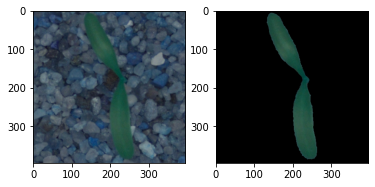

In [9]:
# For segmenting training set images
if GEN_DATA:
  # Creating the folder to save segmented training images
  if not os.path.isdir(TRAIN_SEG_PATH):
      os.mkdir(TRAIN_SEG_PATH) # Create directory for segmented training images
      
  f, axarr = plt.subplots(1,2) # For showing a sample image

  # Segmenting the training data       
  for idx, label in enumerate(labels):

    folder = os.path.join(DATA_DIR, "train", label) # Get path to label folder

    show_img = True
    for img_name in tqdm(os.listdir(folder)): # Iterate through images in training set
      img_path = os.path.join(folder, img_name) # Get path to current image
      img = cv2.imread(img_path, cv2.IMREAD_COLOR) # Read image
      img_seg = segment(img) # Get segmented image
      img_sharp = sharpen(img_seg) # Sharpen segmented image
      seg_path = os.path.join(TRAIN_SEG_PATH, label) # Get path to save segmented image

      if not os.path.isdir(seg_path):
        os.mkdir(seg_path) # Create directory for label in segmented training images folder

      cv2.imwrite(os.path.join(seg_path, img_name), img_sharp) # Save image

      # Plotting a sample
      if show_img:
        show_img = False
        axarr[0].imshow(img)
        axarr[1].imshow(img_seg)

In [10]:
# For segmenting test set images
if GEN_DATA:
  # Creating the folder to save segmented testing images
  if not os.path.isdir(TEST_SEG_PATH):
      os.mkdir(TEST_SEG_PATH) # Create directory for segmented test images
  
  # Segmenting the test data  
  folder = os.path.join(DATA_DIR, "test") # Get path to test set folder

  for img_name in tqdm(os.listdir(folder)): # Iterate through images in test set
    img_path = os.path.join(folder, img_name) # Get path to current image
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # Read image
    img_seg = segment(img) # Get segmented image
    img_sharp = sharpen(img_seg) # Sharpen segmented image
    cv2.imwrite(os.path.join(TEST_SEG_PATH, img_name), img_sharp) # Save image

100%|██████████| 794/794 [10:36<00:00,  1.25it/s]


### 3. Training the model

In [35]:
# Creating a data generator with data augmentation rules
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, # Necessary preprocessing for Xception model
                             height_shift_range=0.3,                  # Change image height by ±0.3
                             horizontal_flip=True,                    # Randomly flip image horizontally
                             rotation_range=180,                      # Rotate image ±180°
                             vertical_flip=True,                      # Randomly flip image vertically
                             width_shift_range=0.3,                   # Change image width ±0.3
                             zoom_range=0.3)                          # Change image zoom ±0.3

In [36]:
# For defining and compiling the model
def create_model():
  initial_model = Xception(weights='imagenet', 
                           input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                           include_top=False)  # Get the original Xception model without dense layers
  x = initial_model.output                     # Get the output of the Xception model
  x = GlobalAveragePooling2D()(x)              # Use global average pooling for spatially averaging each feature map
  x = Dropout(0.5)(x)                          # 50% probability dropout to prevent overfitting
  x = Dense(1024, activation='relu')(x)        # Dense layer with 1024 neurons and ReLU activation function
  x = Dropout(0.5)(x)                          # 50% probability dropout to prevent overfitting
  outputs = Dense(12, activation='softmax')(x) # Dense layer with len(labels) = 12 neurons and softmax activation function
  model = Model(inputs=initial_model.input, outputs=outputs) # Create model based on Xception inputs and custom output layers

  model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) # Compile model
  
  return model

In [37]:
# Generating our list of model instances (based on MODEL_COUNT)
models = []
for i in range(MODEL_COUNT):
  model = create_model()
  models.append(model)

In [38]:
# Initializing the data generator for feeding data to model
train_gen = datagen.flow_from_directory(TRAIN_SEG_PATH,                  # Path where segmented training images are stored
                                       target_size=(IMG_SIZE, IMG_SIZE), # Dimension all images are scaled to before being fed into model
                                       batch_size=BATCH_SIZE,            # Number of images to feed per batch
                                       class_mode='categorical')         # Type of model output

Found 4750 images belonging to 12 classes.


In [39]:
# Defining the learning rate scheduler function
def scheduler(epoch, lr):
  print(f"Learning Rate: {lr}")
  if epoch < 6: # If less than 6 epochs, use original learning rate
    return lr
  else: # If 6th epoch or more, multiply current learning rate by 0.9
    return lr*0.9

In [40]:
# Training the models
histories = [] # For storing model training history

for i in range(MODEL_COUNT):
  model_path = f'{DATA_DIR}/Xception{SAVE_VERSION}_{i}.h5' # Destination where model must be saved

  lr_callback = LearningRateScheduler(scheduler) # Defining learning rate scheduler callback

  # Defining the checkpoint saving callback (saves the weights of the best model till 30 steps)
  ckpt_callback = ModelCheckpoint(
      filepath=model_path,                        # Where model weights will be saved
      save_weights_only=True,                     # Save weights instead of entire model details
      monitor='accuracy',                         # Metric to decide whether to update saved weights
      mode='max',                                 # Save max of previous and current accuracy
      save_freq=TRAIN_IMG_COUNT//(10*BATCH_SIZE), # How often to save = every 30 steps
      save_best_only=True)                        # Only save the best model's weights till now

  print(f"=== Model Number: {i+1} ===")
  history = models[i].fit(train_gen,                         # Using previously defined training data generator
                          steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE, # Number of steps in each epoch
                          epochs=EPOCHS,                               # Number of total epochs
                          callbacks=[lr_callback, ckpt_callback],      # Callbacks to use - learning rate scheduler and checkpoint saver
                          verbose=1)                                   # Print training logs at verbosity level 1
  histories.append(history) # Append training history to list of histories

=== Model Number: 1 ===
Epoch 1/30
Learning Rate: 0.0010000000474974513
296/296 [==============================] - 184s 609ms/step - loss: 1.6991 - accuracy: 0.4603
Epoch 2/30
Learning Rate: 0.0010000000474974513
296/296 [==============================] - 177s 598ms/step - loss: 0.7545 - accuracy: 0.7602
Epoch 3/30
Learning Rate: 0.0010000000474974513
296/296 [==============================] - 170s 572ms/step - loss: 0.5801 - accuracy: 0.8043
Epoch 4/30
Learning Rate: 0.0010000000474974513
296/296 [==============================] - 171s 578ms/step - loss: 0.4947 - accuracy: 0.8390
Epoch 5/30
Learning Rate: 0.0010000000474974513
296/296 [==============================] - 170s 574ms/step - loss: 0.4346 - accuracy: 0.8592
Epoch 6/30
Learning Rate: 0.0010000000474974513
296/296 [==============================] - 174s 587ms/step - loss: 0.3809 - accuracy: 0.8714
Epoch 7/30
Learning Rate: 0.0010000000474974513
296/296 [==============================] - 171s 578ms/step - loss: 0.3535 - accura

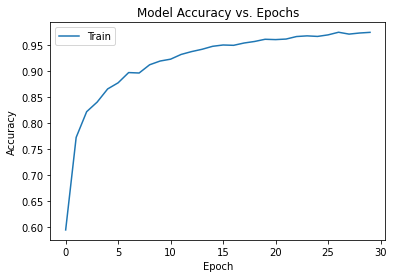

In [41]:
# Plotting model training set accuracies vs. epochs
for i in range(MODEL_COUNT):
  plt.plot(histories[i].history['accuracy'], label="Train")
  plt.title('Model Accuracy vs. Epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

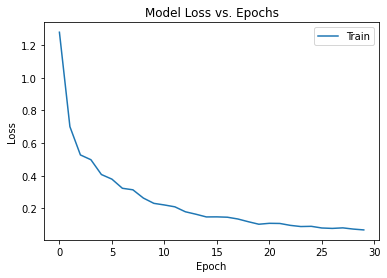

In [42]:
# Plotting model training set losses vs. epochs
for i in range(MODEL_COUNT):
  plt.plot(histories[i].history['loss'], label="Train")
  plt.title('Model Loss vs. Epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

### 4. Running model on test set and saving the submission

In [43]:
# Loading the model weights
models = []
for i in range(MODEL_COUNT):
  model = create_model()

  model_path = f'{DATA_DIR}/Xception{SAVE_VERSION}_{i}.h5'
  model.load_weights(model_path)
  models.append(model)

In [44]:
# Running the models on the test sets and saving the submission file
with open(SUBMISSION_PATH, 'w') as f: # Open path for saving submission CSV

  f.write('file,species\n') # Write headers to CSV

  for img_name in tqdm(os.listdir(TEST_SEG_PATH)): # Iterate through each image in the test set
    img = image.load_img(
        os.path.join(TEST_SEG_PATH, img_name), 
        target_size=(IMG_SIZE, IMG_SIZE))  # Load current image and scale to size required by model
    input = image.img_to_array(img)        # Convert image to numpy array
    input = np.expand_dims(input, axis=0)  # Add a dimension at 0th index        
    probs = np.zeros([12,])                # Create placeholder for predictions (size = [12,1])
    for model in models: # Iterate through each of our trained models
      for augmentation_count, img_augmented in enumerate(datagen.flow(input)): # Iterate through each version of image after test set augmentation
        probs += model.predict(img_augmented)[0] # Add probability for each label to probs placeholder
        if augmentation_count > 100: # Quit prediction for this image if more than 100 augmentation instances
          break
    f.write('{},{}\n'.format(img_name, labels[ np.where(probs == np.max(probs))[0][0] ]) ) # Select label which had highest probability in probs

100%|██████████| 794/794 [1:22:58<00:00,  6.27s/it]
